In [1]:
# Adapted from https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Rather than Torch, for example

import keras
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import keras.backend as K
import random
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal
import sklearn
from sklearn import model_selection
import tensorflow as tf

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# TODO! Read in the data, make sure it's numeric
X = pd.read_csv("../milestone_cohort.csv")
X = X.iloc[:,4:]

# Do whatever data wrangling you need to do on X in this cell...
# ...
X.shape


(52693, 24)

In [8]:
# TODO! Set the train/test size
X_train, X_test = sklearn.model_selection.train_test_split(X, train_size = 0.8)# #test_size=0.01)

# Convert your inputs to numpy arrays (Keras doesn't play nice with pandas dataframes)
X_train = np.array(X_train)
X_test = np.array(X_test)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
def evaluate_vae_model(X_train, X_test, latent_dimensions, intermediate_dimensions):
    
    #Hyperparameters of interest
    intermediate_dim = intermediate_dimensions
    latent_dim = latent_dimensions
    
    # Other hyperparameters
    original_dim = X_test.shape[1]  # Calculated automatically
    batch_size = X_test.shape[0]  # This might affect the learning rate, but shouldn't affect the overall model outcome
    n_epochs = 100  # Not important when we use the early stopping method (as we do in this method)
    epsilon_std = 1.0  # This shouldn't significantly change the model performance, as the z_log_sigma will adjust to accommodate
    
    # The Encoder
    inputs = Input(shape=(original_dim,))
    hidden = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, activation='linear')(hidden)
    z_log_sigma = Dense(latent_dim, activation='linear')(hidden)
    
    # The sampler
    def sample_z(args):
        z_mean, z_log_sigma = args
        eps = K.random_normal(shape=(K.shape(inputs)[0], latent_dim), # Consider changing batch_size here to K.shape(inputs)[0]
                             mean=0., stddev=1.)
        print( z_mean + K.exp(z_log_sigma / 2) * eps)
        return z_mean + K.exp(z_log_sigma / 2) * eps  # Element-wise product of SD with gaussian noise, + mean vector

    z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # The Decoder
    decoder_h = Dense(intermediate_dim, activation='relu')  # We don't specify the inputs because we'll use...
    decoder_mean = Dense(original_dim, activation='linear')  # ...the same layers again for the generator model below
    decoder_log_sigma = Dense(original_dim, activation='linear')
    h_decoded = decoder_h(z)
    output_decoded_mean = decoder_mean(h_decoded)  # Our output is a mean vector (point estimate) and...
    output_decoded_log_sigma = decoder_log_sigma(h_decoded)  # ...a log_sigma, or log_variance vector...
                                                            # which quantifies our certainty about the point estimate
        
    # The end-to-end autoencoder
    vae = Model(inputs, output_decoded_mean)

    # An encoder, from inputs to the latent space
    encoder = Model(inputs, z_mean)

    # A generator, from the latent space to the reconstructed inputs
    generator_input = Input(shape=(latent_dim,))
    generator_h_decoded = decoder_h(generator_input)
    generator_output_decoded_mean = decoder_mean(generator_h_decoded)
    generator_output_decoded_log_sigma = decoder_log_sigma(generator_h_decoded)  # TODO!
    generator = Model(generator_input, [generator_output_decoded_mean, generator_output_decoded_log_sigma])
    
    def vae_loss(y_true, y_pred):
        """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
        # -E[log P(X|z)]    
        reconstruction_loss = neg_log_likelihood(y_true, y_pred)  # TODO! Make the reconstruction loss a proper likelihood loss

        # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
        kl_loss = KL_divergence_loss(y_true, y_pred)

        return reconstruction_loss + kl_loss

    def neg_log_likelihood(y_true, y_pred):
        """ Calculate a proper negative log-likelihood where NLL = -log p(y_pred | mu=y_true, sigma=output_decoded_log_sigma)"""
        negative_log_likelihood = (1./2.) * \
                        (
                            K.int_shape(inputs)[1] * K.log(2. * np.pi) + \
                            K.sum(output_decoded_log_sigma, axis=-1, keepdims=True) + \
                            K.sum(
                                K.square(y_true - y_pred) * (1. / K.exp(output_decoded_log_sigma)), 
                                axis=-1, keepdims=True
                            )
                        )
        return negative_log_likelihood
    
    # An alternative loss function... should give similar results as the above, but isn't a proper NLL per-se
    def squared_difference_loss(y_true, y_pred):
        """ Calculate a naive reconstruction loss, i.e. ||y_true - y_pred||^2 """
        return K.sum(K.square(y_true - y_pred), axis=-1)  # TODO! This isn't strictly speaking the NLL, but it's a half decent approximation for now

    def KL_divergence_loss(y_true, y_pred):
        """ Calculate the KL Divergence portion of the loss, i.e. D_KL(Q(z|X) || P(z|X)) """
        return 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=-1)

    vae.compile(optimizer='rmsprop', 
                loss=vae_loss, 
                metrics=[squared_difference_loss, 
                         KL_divergence_loss, 
                         neg_log_likelihood
                        ]
               )

    # define an early stopping callback criterion so that we don't overfit
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',  # The quantity to be monitored
                                             min_delta=0.0001,  # Minimum change in the monitored quantity in order to qualify
                                                                # as an improvement (if an absolute change of less than min_delta occurs,
                                                                # will not count as no improvement)
                                             patience=10,  # The number of epochs with no improvement after which training will be stopped
                                             verbose=0,  # Verbosity mode
                                             mode='min')  # Training will stop when the quantity monitored has stopped decreasing
    
    callbacks_list = [earlystop]
    
    history = vae.fit(X_train,
                      X_train,
                      shuffle=True,
                      epochs=n_epochs,
                      verbose=0,
                      batch_size=batch_size,
                      callbacks=callbacks_list,
                      validation_split=0.3)
    
    X_test_encoded = encoder.predict(X_test)
    X_test_decoded_mean, X_test_decoded_log_sigma = generator.predict(X_test_encoded)
    test_nll = (1./2.) * \
               (
                   X_test.shape[1] * np.log(2. * np.pi) + \
                   np.sum(X_test_decoded_log_sigma, axis=-1, keepdims=True) + \
                   np.sum(
                       np.square(X_test - X_test_decoded_mean) * (1. / np.exp(X_test_decoded_log_sigma)), 
                       axis=-1, keepdims=True
                   )
               )
    
    return np.mean(test_nll), vae, encoder, generator, history

In [10]:
n_z = 4 # number latent vars
test_err, vae, encoder, generator, history = evaluate_vae_model(X_train, X_test, n_z, 500)

Tensor("lambda_1/add:0", shape=(?, 4), dtype=float32)


In [11]:
X_train[0]

array([ 0.91340739,  0.14335674, -0.55893423,  1.49867838, -0.79549249,
        0.12485102, -0.05609363, -0.26803683, -0.66310917, -0.02270339,
       -0.34537274, -0.58956481, -0.80207591, -0.4278322 , -0.46921324,
        0.10557583,  0.64969354, -0.41548605, -0.10841705, -0.45290728,
       -0.35380497, -1.06096236, -0.03241915,  0.30306297])

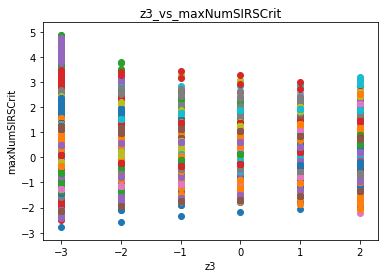

In [12]:
names = list(X.columns)
n_examples = 50

old_pats = X_train[:n_examples]
zvals = encoder.predict(old_pats)
#get some known patients.
min_z = -3
max_z = 3
skip = 1

latent_vars = {}

for i in range(n_z): # for each latent variable
    latent_name = "z" + str(i)
    latent_vars[latent_name] = {}
    layer = latent_vars[latent_name]
    for z in range(min_z, max_z,skip):# set as arbitrary value
        zvals[:,i] = z
        new_pats = generator.predict(zvals)
        new_z = np.ones(n_examples) * z
        if "x" in layer:
            layer["x"] = np.concatenate((layer["x"], new_pats[0]))
        else:
            layer["x"] = new_pats[0]
        if "z" in layer:
            layer["z"] = np.concatenate((layer["z"], new_z), axis=0)
        else:
            layer["z"] = new_z
new_pats
#plot each latent variable against each real value
x_z_data = [] #{x: xvals, z: zvals, varname}
fignum = 0
for z_i in range(n_z):
    latent_varname = "z" + str(z_i)
    for j, real_varname in enumerate(names):
        fignum += 1
        title = latent_varname + "_vs_" + real_varname
        x_data = latent_vars[latent_varname]["x"][:,j]
        z_data = latent_vars[latent_varname]["z"]

#       plt.figure(fignum)
        plt.scatter(z_data, x_data) #we control the hidden var, z.
        plt.title(title)
        plt.xlabel(latent_varname)
        plt.ylabel(real_varname)
        plt.savefig("figures/title"+".png")
        

In [179]:
plt.figure(1)

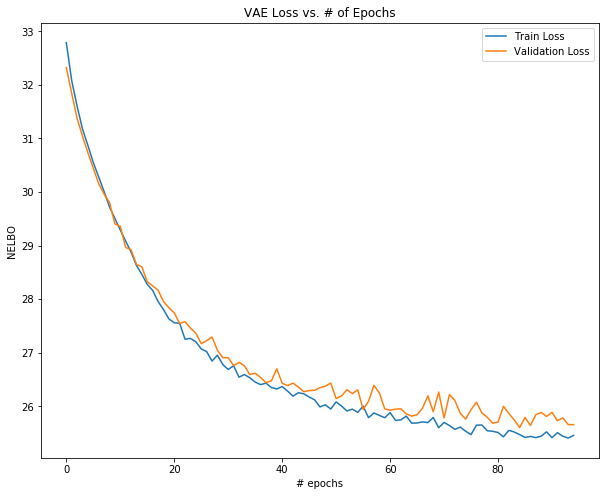

In [93]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')

ax.legend()


ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

plt.title('VAE Loss vs. # of Epochs')
plt.show()

In [94]:
print(generator.predict(encoder.predict(X_test)))

[array([[ 0.2515052 ,  0.06865831,  0.38046807, ...,  0.08268391,
         0.17411569,  0.15812518],
       [-1.1256908 , -0.68406534,  0.2790796 , ...,  0.1080014 ,
        -0.2190349 , -1.3732514 ],
       [ 0.5546796 ,  0.05441567,  0.12773016, ..., -0.5204516 ,
         0.0911508 ,  0.18978366],
       ...,
       [ 0.7196886 ,  0.47617283, -0.14462012, ..., -0.23795474,
         0.2969438 ,  0.85295326],
       [-0.48841602, -0.4465626 ,  0.23522341, ...,  0.16924036,
        -0.08032832, -0.52968186],
       [ 0.45184812,  0.08551691,  0.080309  , ..., -0.04397183,
         0.08701947,  0.6257931 ]], dtype=float32), array([[-0.39726642, -0.05609443, -0.03326736, ...,  0.00591087,
        -1.0210907 , -0.78294116],
       [-0.56958956, -0.7086217 , -0.01649725, ..., -0.5593717 ,
        -1.9347425 , -0.6185842 ],
       [-0.56598234, -0.2135876 , -0.5622438 , ..., -0.9258385 ,
        -2.0248682 , -1.1109654 ],
       ...,
       [-0.14343238,  0.2069656 , -0.58150685, ..., -0.555

### A Note on the Generator...

In [54]:
# This function is deterministic...
for i in range(10):
    print(np.mean(np.sum(np.square(X_test - generator.predict(encoder.predict(X_test))), axis=1)))

12660.049752018154
12660.049752018154
12660.049752018154
12660.049752018154
12660.049752018154
12660.049752018154
12660.049752018154
12660.049752018154
12660.049752018154
12660.049752018154


In [55]:
# ...but this function is stochastic
for i in range(10):
    print(np.mean(np.sum(np.square(X_test - vae.predict(X_test)), axis=1)))

10.73937341614385
10.734808142046559
10.696579781395878
10.778514440066154
10.74440307463011
10.701515409307124
10.724644009823312
10.700494391834201
10.706590498031078
10.67101639222082


## Grid Search to get the right number of hidden variables...

In [47]:
from sklearn.model_selection import KFold
X = pd.read_csv("all.dat.csv")
X = X.drop(['participant_id'], axis=1)
X = X.set_index(['subNum'])
X_mat = np.array(X)

n_folds = 5
num_latent_vars = [5, 10, 15, 20, 25, 30, 50, 75, 100, 150, 250, 500, 1000]
num_hidden_vars = [10, 25, 50, 100, 250, 500, 750, 1000, 1500, 2500, 5000]
cv_results = pd.DataFrame(0,
                           index=num_latent_vars,
                           columns=num_hidden_vars)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
kf.get_n_splits(X_mat)

i = 1
for lat_var_num in num_latent_vars:
    for hid_var_num in num_hidden_vars:
        fold_num = 1
        total_nll = 0.
        
        print('Simulation #{}: VAE with {} Latent Variable(s) and {} Hidden Variable(s)...'.format(i, lat_var_num, hid_var_num))
        
        for train_index, test_index in kf.split(X_mat):
            X_train, X_test = X_mat[train_index], X_mat[test_index]
            print("\tEvaluating model on Fold {}".format(fold_num))
            total_nll += evaluate_vae_model(X_train, 
                                            X_test, 
                                            latent_dimensions=lat_var_num, 
                                            intermediate_dimensions=hid_var_num)
            fold_num += 1

        cv_results.loc[lat_var_num, hid_var_num] = total_nll / n_folds
        print('\tAvgerage Negative Log-Likelihood = {}'.format(total_nll / n_folds))
        i += 1

FileNotFoundError: File b'/Users/scottyf/Documents/RAD_Analysis/RAD_data/data_frames/all.dat.csv' does not exist

In [13]:
import seaborn as sns
sns.heatmap(-my_cv_results)
plt.xlabel('# Hidden Layer Variables')
plt.ylabel('# Latent Variables')
plt.show()

NameError: name 'my_cv_results' is not defined

### A comparison with PCA and Factor Analysis, after SciKit Learn's http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py

In [21]:
from sklearn.decomposition import PCA
num_simulations = 10
num_latent_vars = range(1, 51)
pca_sim_results = pd.DataFrame(0, 
                           index=range(1, num_simulations * len(num_latent_vars) + 1), 
                           columns=['simulation', 
                                    'num_latent_vars', 
                                    'squared_error'])

i = 0
for lat_var_num in num_latent_vars:
    for sim_num in range(1, num_simulations + 1):
        X_train, X_test = sklearn.model_selection.train_test_split(X, train_size = 0.7)
        pca_model = PCA(n_components=lat_var_num)
        pca_model.fit(X_train)
        X_test_pca = pca_model.transform(X_test)
        X_test_pca_estimate = pca_model.inverse_transform(X_test_pca)
        recon_err = np.mean(np.sum(np.square(X_test - X_test_pca_estimate), axis=1))
        
        print('Simulation #{} VAE with {} Latent Variable(s)...'.format(sim_num, lat_var_num))

        pca_sim_results.iloc[i, :] = [sim_num, 
                                      lat_var_num,
                                      recon_err]
        i += 1

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Simulation #1 VAE with 1 Latent Variable(s)...
Simulation #2 VAE with 1 Latent Variable(s)...


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Simulation #3 VAE with 1 Latent Variable(s)...
Simulation #4 VAE with 1 Latent Variable(s)...
Simulation #5 VAE with 1 Latent Variable(s)...
Simulation #6 VAE with 1 Latent Variable(s)...
Simulation #7 VAE with 1 Latent Variable(s)...
Simulation #8 VAE with 1 Latent Variable(s)...
Simulation #9 VAE with 1 Latent Variable(s)...
Simulation #10 VAE with 1 Latent Variable(s)...
Simulation #1 VAE with 2 Latent Variable(s)...
Simulation #2 VAE with 2 Latent Variable(s)...
Simulation #3 VAE with 2 Latent Variable(s)...
Simulation #4 VAE with 2 Latent Variable(s)...
Simulation #5 VAE with 2 Latent Variable(s)...
Simulation #6 VAE with 2 Latent Variable(s)...
Simulation #7 VAE with 2 Latent Variable(s)...
Simulation #8 VAE with 2 Latent Variable(s)...
Simulation #9 VAE with 2 Latent Variable(s)...
Simulation #10 VAE with 2 Latent Variable(s)...
Simulation #1 VAE with 3 Latent Variable(s)...
Simulation #2 VAE with 3 Latent Variable(s)...
Simulation #3 VAE with 3 Latent Variable(s)...
Simulation 

Simulation #6 VAE with 18 Latent Variable(s)...
Simulation #7 VAE with 18 Latent Variable(s)...
Simulation #8 VAE with 18 Latent Variable(s)...
Simulation #9 VAE with 18 Latent Variable(s)...
Simulation #10 VAE with 18 Latent Variable(s)...
Simulation #1 VAE with 19 Latent Variable(s)...
Simulation #2 VAE with 19 Latent Variable(s)...
Simulation #3 VAE with 19 Latent Variable(s)...
Simulation #4 VAE with 19 Latent Variable(s)...
Simulation #5 VAE with 19 Latent Variable(s)...
Simulation #6 VAE with 19 Latent Variable(s)...
Simulation #7 VAE with 19 Latent Variable(s)...
Simulation #8 VAE with 19 Latent Variable(s)...
Simulation #9 VAE with 19 Latent Variable(s)...
Simulation #10 VAE with 19 Latent Variable(s)...
Simulation #1 VAE with 20 Latent Variable(s)...
Simulation #2 VAE with 20 Latent Variable(s)...
Simulation #3 VAE with 20 Latent Variable(s)...
Simulation #4 VAE with 20 Latent Variable(s)...
Simulation #5 VAE with 20 Latent Variable(s)...
Simulation #6 VAE with 20 Latent Varia

ValueError: n_components=29 must be between 0 and n_features=28 with svd_solver='full'

In [ ]:
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

print(__doc__)

# #############################################################################
# Fit the models

n_components = np.arange(1, 50, 1)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        if n % 10 == 0:
            print ("Running PCA/FA for {} Components...".format(n))
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X))) # Return the average log-likelihood of all samples.
        fa_scores.append(np.mean(cross_val_score(fa, X))) # Return the average log-likelihood of all samples.

    return pca_scores, fa_scores

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))

def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

pca_scores, fa_scores = compute_scores(X)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

pca = PCA(svd_solver='full', n_components='mle')
pca.fit(X)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

In [ ]:
plt.figure()

#plt.plot(num_latent_vars[:6], -cv_results.loc[num_latent_vars[:6],150], 'g', label='VAE scores')

plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.axvline(n_components_pca, color='b',
            label='PCA CV: %d' % n_components_pca, linestyle='--')

plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(n_components_fa, color='r',
            label='FactorAnalysis CV: %d' % n_components_fa,
            linestyle='--')


plt.axhline(lw_score(X), color='orange',
            label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

plt.xlabel('Number of Components')
plt.ylabel('Log-Likelihood')
# plt.ylabel('CV scores')
plt.legend(loc='lower right')

plt.show()